### Import Dataset and Organize the Dataframe

In [57]:
# Let's import the necessary libraries
import pandas as pd

# Read in the dataset 
df = pd.read_csv('wgm_full_wave2_public_file_final_csv.csv',na_values=" ", keep_default_na=False,low_memory=False)

# Organizing the dataset:

# DEMOGRAPHIC INFORMATION
# Copy the original dataframe and select the columns associated with demograph information. 
#  These demographic factors are categorical variables; convert the datatype to 'categorical'
demographicInfo = df.copy()[['Global11Regions','Gender', 'Age','age_var3',
                             'Education','Household_Income','wbi',
                             'Subjective_Income','EMP_2010']].astype('category')

# First we add a new level/category of '99.0' to the feature:
demographicInfo['Household_Income'] = demographicInfo['Household_Income'].cat.add_categories(99.0)
demographicInfo['EMP_2010'] = demographicInfo['EMP_2010'].cat.add_categories(99.0)

# Impute the NaN values with '99.0' ('Don't Know/Refused')
demographicInfo['Household_Income'].fillna(99.0, inplace=True)
demographicInfo['EMP_2010'].fillna(99.0, inplace=True)


# QUESTIONNAIRE DATA
# Perception of science:
sciPercep = df.copy().iloc[:,6:28].astype('category')
sciPercep['W3'] = sciPercep['W3'].cat.add_categories(99.0) # Add a new level to 'W3'
sciPercep['W3'].fillna(99.0, inplace=True) # Impute the NaN values with the new level

# Impute the NaN entries with the values stated above
sciPercep['W4'].fillna(99.0, inplace=True)
sciPercep['W5B'].fillna(99.0, inplace=True)
sciPercep['W5D'].fillna(99.0, inplace=True)
sciPercep['W7C'].fillna(99.0, inplace=True)


# Perceptions about Climate Change
climateChange = df.copy().iloc[:,28:31].astype('category')
# Impute the NaN entries with the values stated above
climateChange['W14'].fillna(99.0, inplace=True)
climateChange['W15'].fillna(99.0, inplace=True)


# Perceptions of science with respect to COVID-19 pandemic
covidPercep = df.copy().iloc[:,31:38].astype('category')
# Impute the NaN entries with the values stated above
covidPercep['W15_1A'].fillna(99.0, inplace=True)
covidPercep['W15_1B'].fillna(99.0, inplace=True)
covidPercep['W15_1C'].fillna(99.0, inplace=True)
covidPercep['W15_1D'].fillna(99.0, inplace=True)
covidPercep['W15_1E'].fillna(99.0, inplace=True)
covidPercep['W15_2A'].fillna(99.0, inplace=True)
covidPercep['W15_2B'].fillna(99.0, inplace=True)


# Perceptions about physical and mental health:
sciHealth = df.copy().iloc[:,38:67].astype('category')
# Impute the NaN entries with the values stated above for MH3A to MH5 + MH7A
sciHealth['MH3A'].fillna(99.0, inplace=True)
sciHealth['MH3B'].fillna(99.0, inplace=True)
sciHealth['MH3C'].fillna(99.0, inplace=True)
sciHealth['MH3D'].fillna(99.0, inplace=True)
sciHealth['MH4A'].fillna(99.0, inplace=True)
sciHealth['MH4B'].fillna(99.0, inplace=True)
sciHealth['MH5'].fillna(99.0, inplace=True)
sciHealth['MH7A'].fillna(99.0, inplace=True)
# Impute the NaN entries with the values stated above for MH1 and MH6
sciHealth['MH1'].fillna(99, inplace=True)
sciHealth['MH6'].fillna(99, inplace=True)


# Social Media Usage
socialMedia = df.copy().iloc[:,67:70].astype('category')
# Impute the NaN values
socialMedia['W28'].fillna(99.0, inplace=True)
socialMedia['W29'].fillna(99.0, inplace=True)


# Religion
religion = df.copy()['W30'].astype('category')

# Impute missing values
religion.fillna(99.0, inplace=True)

Generating the final dataset used for Classification

In [58]:
questionDataset = pd.concat([sciPercep, climateChange, covidPercep,sciHealth.iloc[:,0:10], socialMedia, religion.to_frame()],axis=1)
# Remove 'Age' and keep 'age_var3'
demographicInfo = demographicInfo.drop('Age',axis=1)

dataset = pd.concat([demographicInfo, questionDataset],axis=1)
dataset.shape # 119 088 entries and 54 columns/features

(119088, 54)

In [59]:
dataset = dataset[(dataset['MH7A'] == 1.0) | (dataset['MH7A'] == 2.0)]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116810 entries, 0 to 119087
Data columns (total 54 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Global11Regions    116810 non-null  category
 1   Gender             116810 non-null  category
 2   age_var3           116810 non-null  category
 3   Education          116810 non-null  category
 4   Household_Income   116810 non-null  category
 5   wbi                116810 non-null  category
 6   Subjective_Income  116810 non-null  category
 7   EMP_2010           116810 non-null  category
 8   W1                 116810 non-null  category
 9   W2                 116810 non-null  category
 10  W3                 116810 non-null  category
 11  W4                 116810 non-null  category
 12  W5A                116810 non-null  category
 13  W5B                116810 non-null  category
 14  W5C                116810 non-null  category
 15  W5D                116810 non-null

### Classification

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Splitting the dataset into features and target/label:

In [61]:
y = dataset['MH7A'] # The label: MH7A 
y.shape # 119 088 entries

(116810,)

In [62]:
X = dataset.drop(columns='MH7A') # The independent variables/features used for classification
X.shape # 119 088 entries and 54 columns/features

(116810, 53)

Split the dataset into training/testing sets using a 70/30 split:

In [63]:
# 70% training and 30% test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

In [64]:
X_train.shape

(81767, 53)

In [65]:
X_test.shape

(35043, 53)

### Feature Selection

Based on the chi-squared test scores shown, let's set a threshold of 2000. Any features that have a score greater than 2000 will be included as a feature in future models.

Feature 0: 895.456901
Feature 1: 16.520788
Feature 2: 429.357539
Feature 3: 206.765457
Feature 4: 846.724313
Feature 5: 39.561801
Feature 6: 711.372076
Feature 7: 59.517958
Feature 8: 78.933518
Feature 9: 264.673228
Feature 10: 802.682457
Feature 11: 839.676847
Feature 12: 149.290457
Feature 13: 3299.105630
Feature 14: 18.832843
Feature 15: 8.387719
Feature 16: 13.242311
Feature 17: 1258.828622
Feature 18: 830.888446
Feature 19: 97.691066
Feature 20: 767.574079
Feature 21: 1735.630512
Feature 22: 1669.939171
Feature 23: 383.940229
Feature 24: 974.274333
Feature 25: 1157.068725
Feature 26: 2035.334654
Feature 27: 1943.582749
Feature 28: 246.275184
Feature 29: 3425.815844
Feature 30: 429.198579
Feature 31: 852.821591
Feature 32: 1377.413362
Feature 33: 11101.115091
Feature 34: 14531.825730
Feature 35: 15976.569347
Feature 36: 14023.354942
Feature 37: 12520.446012
Feature 38: 9385.945667
Feature 39: 9706.794076
Feature 40: 133.277412
Feature 41: 1182.391846
Feature 42: 10621.389196
Featur

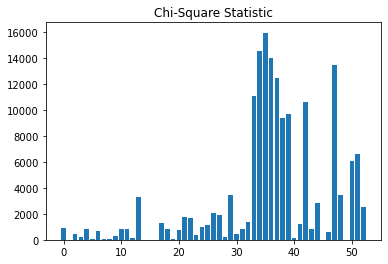

In [66]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# # Using the Chi-Squared test to identify features that are NOT independent of the target variable/label
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

# what are scores for the features
for i in range(len(fs.scores_)):
 print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.title('Chi-Square Statistic')
plt.show()

In [67]:
selector = SelectKBest(score_func=chi2, k=17)
selector.fit(X_train, y_train)
# Get columns to keep and create new dataframe with those only
cols_idxs = selector.get_support(indices=True)
X_fs = X_train.iloc[:,cols_idxs]

In [68]:
X_fs

,W5B,W11A,MH2B,W15_1A,W15_1B,W15_1C,W15_1D,W15_1E,W15_2A,W15_2B,MH3B,MH3D,MH5,MH6,W28,W29,W30
43560,2.0,1,2,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,99,99.0,99.0,1.0
62908,4.0,1,99,4.0,3.0,1.0,1.0,99.0,3.0,1.0,3.0,99.0,1.0,2,3.0,3.0,3.0
34789,2.0,1,2,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2,99.0,99.0,2.0
55266,1.0,2,1,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0
75584,99.0,1,3,1.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,2,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50736,1.0,3,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2,3.0,3.0,4.0
99189,99.0,1,4,99.0,1.0,2.0,2.0,99.0,1.0,1.0,2.0,3.0,1.0,1,1.0,2.0,1.0
5214,3.0,1,1,3.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,1,3.0,2.0,2.0
78640,3.0,1,3,2.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,3.0,2,2.0,3.0,1.0


In [69]:
# Let's add the demographic features into X_fs:
X_train_fs = pd.concat([X_train.iloc[:,1], X_fs],axis=1)
X_train_fs

,Gender,W5B,W11A,MH2B,W15_1A,W15_1B,W15_1C,W15_1D,W15_1E,W15_2A,W15_2B,MH3B,MH3D,MH5,MH6,W28,W29,W30
43560,2,2.0,1,2,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,99,99.0,99.0,1.0
62908,1,4.0,1,99,4.0,3.0,1.0,1.0,99.0,3.0,1.0,3.0,99.0,1.0,2,3.0,3.0,3.0
34789,2,2.0,1,2,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2,99.0,99.0,2.0
55266,2,1.0,2,1,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0
75584,2,99.0,1,3,1.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,2,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50736,2,1.0,3,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2,3.0,3.0,4.0
99189,1,99.0,1,4,99.0,1.0,2.0,2.0,99.0,1.0,1.0,2.0,3.0,1.0,1,1.0,2.0,1.0
5214,2,3.0,1,1,3.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,1,3.0,2.0,2.0
78640,2,3.0,1,3,2.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,3.0,2,2.0,3.0,1.0


Let's define some scoring metrics

In [70]:
# Define custom scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}

#### Classification using smaller Feature Set

First let's update X_test with the new features:

In [71]:
X_train_fs.info() # 18 features now being used

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81767 entries, 43560 to 99685
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Gender  81767 non-null  category
 1   W5B     81767 non-null  category
 2   W11A    81767 non-null  category
 3   MH2B    81767 non-null  category
 4   W15_1A  81767 non-null  category
 5   W15_1B  81767 non-null  category
 6   W15_1C  81767 non-null  category
 7   W15_1D  81767 non-null  category
 8   W15_1E  81767 non-null  category
 9   W15_2A  81767 non-null  category
 10  W15_2B  81767 non-null  category
 11  MH3B    81767 non-null  category
 12  MH3D    81767 non-null  category
 13  MH5     81767 non-null  category
 14  MH6     81767 non-null  category
 15  W28     81767 non-null  category
 16  W29     81767 non-null  category
 17  W30     81767 non-null  category
dtypes: category(18)
memory usage: 2.0 MB


In [72]:
# Get columns to keep and create new dataframe with those only
cols_idxs = selector.get_support(indices=True)
X_test_fs = X_test.iloc[:,cols_idxs]

# The testing set to be used
X_test_fs = pd.concat([X_test.iloc[:,1],X_test_fs],axis=1)

In [73]:
X_test_fs.shape

(35043, 18)

### Random Forest Classifier

In [74]:
from sklearn.ensemble import RandomForestClassifier

#### 10-fold Cross-validation

In [75]:
# Create Random Forest Classifier object
clf_RF = RandomForestClassifier()

# Perform 10-fold cross-validation with custom scoring metrics
cv_results = cross_validate(clf_RF, X_train_fs, y_train, cv=10, scoring=scoring)

# Print the results
print(cv_results)

{'fit_time': array([7.88579178, 7.7517395 , 7.77276683, 7.77676749, 7.82977962,
       7.75074792, 7.82677937, 7.74575162, 7.84275413, 7.7307446 ]), 'score_time': array([0.21504259, 0.22404552, 0.21803474, 0.21703529, 0.2190361 ,
       0.22705293, 0.21905231, 0.21304202, 0.21506095, 0.21603417]), 'test_accuracy': array([0.79209979, 0.78476214, 0.78818638, 0.78659655, 0.79173291,
       0.78830867, 0.78892014, 0.79378669, 0.78742661, 0.79219667]), 'test_precision': array([0.48044693, 0.42831858, 0.45009416, 0.43678161, 0.47674419,
       0.45272727, 0.45454545, 0.49295775, 0.44402277, 0.47826087]), 'test_recall': array([0.15366289, 0.14413341, 0.14234663, 0.13579512, 0.14651578,
       0.14830256, 0.13690476, 0.14592019, 0.13936867, 0.13103038]), 'test_f1_score': array([0.23285199, 0.21568627, 0.21628959, 0.20717856, 0.22414579,
       0.22341857, 0.21043001, 0.22518382, 0.21214869, 0.2057036 ])}


In [76]:
# 10-fold cross-validation
print("Random Forest F1-score\nMean: {mean}\nStd: {std}".format(mean=np.mean(cv_results['test_f1_score']),
                                                                      std=np.std(cv_results['test_f1_score'])))

Random Forest F1-score
Mean: 0.21730368851549886
Std: 0.008382114933411214


#### Using the Testing Set:

In [77]:
# Create Random Forest Classifier object
clf_RF = RandomForestClassifier()

# Fit the model
clf_RF.fit(X_train_fs, y_train)

# Predicting labels for the Test Set
y_pred_RF = clf_RF.predict(X_test_fs)

print(confusion_matrix(y_test, y_pred_RF))

# TN, FP
# FN, TP
## y_pred: Predicted labels
## y_test: True Labels

[[ 1124  6056]
 [ 1291 26572]]


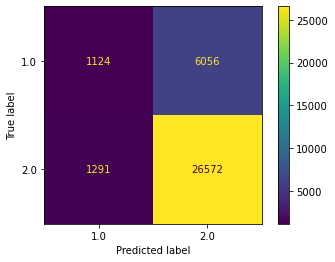

In [78]:
cm = confusion_matrix(y_test, y_pred_RF, labels=clf_RF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_RF.classes_)
disp.plot()
plt.show()

In [79]:
print("Accuracy:", accuracy_score(y_test, y_pred_RF))
print("Precision:", precision_score(y_test, y_pred_RF))
print("Recall:", recall_score(y_test, y_pred_RF))
print("F1 Score:", f1_score(y_test, y_pred_RF))

Accuracy: 0.7903432925263248
Precision: 0.46542443064182193
Recall: 0.1565459610027855
F1 Score: 0.23428869202709743


In [80]:
print(classification_report(y_test, y_pred_RF))

              precision    recall  f1-score   support

         1.0       0.47      0.16      0.23      7180
         2.0       0.81      0.95      0.88     27863

    accuracy                           0.79     35043
   macro avg       0.64      0.56      0.56     35043
weighted avg       0.74      0.79      0.75     35043



### Balancing the dataset
Let's apply an imbalance treatment by undersampling the majority class (i.e. 'No' to MH7A)

In [81]:
from imblearn.under_sampling import RandomUnderSampler

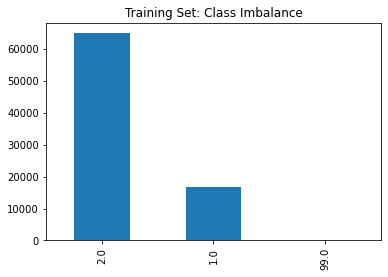

In [82]:
y_train.value_counts().plot(kind='bar', title='Training Set: Class Imbalance');

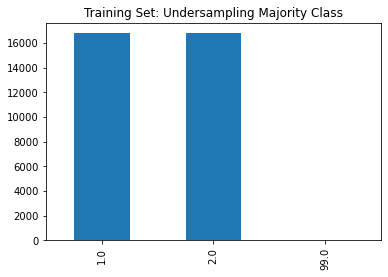

In [83]:
rus = RandomUnderSampler(random_state=1)
X_rus, y_rus = rus.fit_resample(X_train_fs, y_train)
y_rus.value_counts().plot(kind='bar', title='Training Set: Undersampling Majority Class');

#### 10 fold cross-validation

In [84]:
# Create Random Forest Classifier object
clf_RF = RandomForestClassifier()

# Perform 10-fold cross-validation with custom scoring metrics
cv_results = cross_validate(clf_RF, X_rus, y_rus, cv=10, scoring=scoring)

# Print the results
print(cv_results)

{'fit_time': array([2.98367214, 2.95566678, 3.07169318, 2.99368119, 2.95866728,
       2.95265889, 2.95666695, 3.05070186, 2.97368884, 2.96266031]), 'score_time': array([0.08802032, 0.08802056, 0.08903265, 0.09602165, 0.08901978,
       0.0910337 , 0.08701921, 0.08800697, 0.08801508, 0.0900352 ]), 'test_accuracy': array([0.70259006, 0.68919321, 0.69982132, 0.68612269, 0.70011912,
       0.71560453, 0.71113758, 0.71620012, 0.69952353, 0.68910066]), 'test_precision': array([0.70136014, 0.68341999, 0.69700528, 0.68393172, 0.69672131,
       0.70828539, 0.71063577, 0.71632896, 0.69682726, 0.68278641]), 'test_recall': array([0.70595238, 0.70458606, 0.70696843, 0.69207862, 0.70875521,
       0.73317451, 0.71232877, 0.71590232, 0.70637284, 0.70637284]), 'test_f1_score': array([0.70364877, 0.69384164, 0.70195151, 0.68798105, 0.70268674,
       0.72051507, 0.71148126, 0.71611558, 0.70156758, 0.69437939])}


In [85]:
# 10-fold cross-validation; Balanced Dataset
print("Random Forest F1-score\nMean: {mean}\nStd: {std}".format(mean=np.mean(cv_results['test_f1_score']),
                                                                      std=np.std(cv_results['test_f1_score'])))

Random Forest F1-score
Mean: 0.7034168603328899
Std: 0.009676877416469306


In [86]:
# Fit Time
print("Random Forest Average Fit Time: {fit}".format(fit=np.mean(cv_results['fit_time'])))

Random Forest Average Fit Time: 2.985975742340088


Apply on Testing Set:

In [87]:
# Create Random Forest Classifier object
clf_RF = RandomForestClassifier()

# Fit the model
clf_RF.fit(X_rus, y_rus)

# Predicting labels for the Test Set
y_pred_RF = clf_RF.predict(X_test_fs)

print(confusion_matrix(y_test, y_pred_RF))

# TN, FP
# FN, TP
## y_pred: Predicted labels
## y_test: True Labels

[[ 5063  2117]
 [ 8443 19420]]


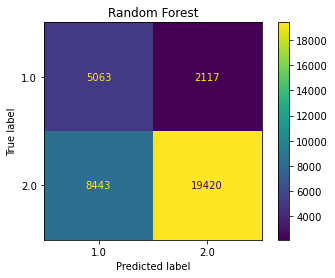

In [90]:
cm = confusion_matrix(y_test, y_pred_RF, labels=clf_RF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_RF.classes_)
disp.plot()
plt.title('Random Forest')
plt.show()

In [91]:
print("Accuracy:", accuracy_score(y_test, y_pred_RF))
print("Precision:", precision_score(y_test, y_pred_RF))
print("Recall:", recall_score(y_test, y_pred_RF))
print("F1 Score:", f1_score(y_test, y_pred_RF))
print("MCC:", matthews_corrcoef(y_test, y_pred_RF))

Accuracy: 0.6986559369916959
Precision: 0.3748704279579446
Recall: 0.7051532033426184
F1 Score: 0.48950981340036737
MCC: 0.33349698295509467


In [92]:
print(classification_report(y_test, y_pred_RF))

              precision    recall  f1-score   support

         1.0       0.37      0.71      0.49      7180
         2.0       0.90      0.70      0.79     27863

    accuracy                           0.70     35043
   macro avg       0.64      0.70      0.64     35043
weighted avg       0.79      0.70      0.73     35043



### Removing the demographic feature of gender
- Only using Behavioural/Beliefs features

In [93]:
X_rus.columns

Index(['Gender', 'W5B', 'W11A', 'MH2B', 'W15_1A', 'W15_1B', 'W15_1C', 'W15_1D',
       'W15_1E', 'W15_2A', 'W15_2B', 'MH3B', 'MH3D', 'MH5', 'MH6', 'W28',
       'W29', 'W30'],
      dtype='object')

In [94]:
X_rus.drop('Gender', axis=1, inplace=True)

In [95]:
X_rus

,W5B,W11A,MH2B,W15_1A,W15_1B,W15_1C,W15_1D,W15_1E,W15_2A,W15_2B,MH3B,MH3D,MH5,MH6,W28,W29,W30
0,2.0,1,2,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2,99.0,99.0,2.0
1,1.0,2,1,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0
2,4.0,1,4,4.0,4.0,1.0,4.0,4.0,2.0,2.0,4.0,1.0,1.0,1,5.0,1.0,1.0
3,1.0,2,3,3.0,4.0,2.0,1.0,4.0,1.0,1.0,2.0,3.0,3.0,2,3.0,3.0,1.0
4,4.0,1,2,2.0,4.0,2.0,2.0,4.0,1.0,4.0,2.0,2.0,3.0,1,3.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33577,2.0,2,3,2.0,2.0,2.0,2.0,4.0,4.0,2.0,2.0,3.0,3.0,2,1.0,3.0,1.0
33578,3.0,2,3,2.0,2.0,1.0,1.0,2.0,4.0,1.0,2.0,1.0,2.0,2,3.0,1.0,2.0
33579,4.0,1,1,4.0,1.0,1.0,1.0,4.0,4.0,1.0,1.0,1.0,2.0,1,4.0,3.0,99.0
33580,1.0,99,99,99.0,99.0,99.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,2,6.0,2.0,99.0


In [96]:
X_test_fs.drop('Gender', axis=1, inplace=True)

In [97]:
# Create Random Forest Classifier object
clf_RF = RandomForestClassifier()

# Perform 10-fold cross-validation with custom scoring metrics
cv_results = cross_validate(clf_RF, X_rus, y_rus, cv=10, scoring=scoring)

# Print the results
print(cv_results)

{'fit_time': array([3.02169394, 2.97066975, 3.01966262, 2.99367332, 3.06270981,
       3.13470578, 3.03469086, 3.01666737, 2.9866724 , 3.0996933 ]), 'score_time': array([0.08902025, 0.08601618, 0.10002327, 0.08903956, 0.10800743,
       0.10902309, 0.0890069 , 0.08603263, 0.08623981, 0.08802605]), 'test_accuracy': array([0.70526943, 0.69127717, 0.69803454, 0.68790947, 0.69535438,
       0.7096486 , 0.70607504, 0.71679571, 0.68671828, 0.69148303]), 'test_precision': array([0.70341981, 0.68838028, 0.695934  , 0.6852613 , 0.6922626 ,
       0.70323326, 0.70257611, 0.71796407, 0.68738793, 0.68616097]), 'test_recall': array([0.71011905, 0.69863014, 0.70339488, 0.69505658, 0.70339488,
       0.7254318 , 0.71471114, 0.71411554, 0.68493151, 0.70577725]), 'test_f1_score': array([0.70675355, 0.69346734, 0.69964455, 0.69012419, 0.69778434,
       0.71416007, 0.70859167, 0.71603464, 0.68615752, 0.69583089])}


In [98]:
# 10-fold cross-validation
print("Random Forest F1-score\nMean: {mean}\nStd: {std}".format(mean=np.mean(cv_results['test_f1_score']),
                                                                      std=np.std(cv_results['test_f1_score'])))

Random Forest F1-score
Mean: 0.700854875669273
Std: 0.009612362321380869


In [102]:
# Create Random Forest Classifier object
clf_RF = RandomForestClassifier()

# Fit the model
clf_RF.fit(X_rus, y_rus)

# Predicting labels for the Test Set
y_pred_RF = clf_RF.predict(X_test_fs)

print(confusion_matrix(y_test, y_pred_RF))

# TN, FP
# FN, TP
## y_pred: Predicted labels
## y_test: True Labels

[[ 5071  2109]
 [ 8461 19402]]


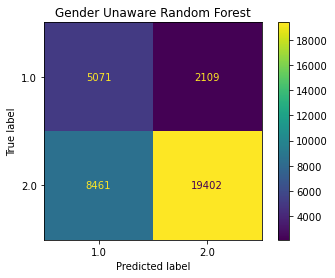

In [109]:
cm = confusion_matrix(y_test, y_pred_RF, labels=clf_RF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_RF.classes_)
disp.plot()
plt.title('Gender Unaware Random Forest')
plt.show()

In [104]:
print("Accuracy:", accuracy_score(y_test, y_pred_RF))
print("Precision:", precision_score(y_test, y_pred_RF))
print("Recall:", recall_score(y_test, y_pred_RF))
print("F1 Score:", f1_score(y_test, y_pred_RF))
print("MCC:", matthews_corrcoef(y_test, y_pred_RF))

Accuracy: 0.6983705732956653
Precision: 0.37474135382796336
Recall: 0.7062674094707521
F1 Score: 0.48966782541521814
MCC: 0.3337658719824972


In [48]:
print(classification_report(y_test, y_pred_RF))

              precision    recall  f1-score   support

         1.0       0.37      0.70      0.49      7180
         2.0       0.90      0.69      0.78     27863

    accuracy                           0.70     35043
   macro avg       0.64      0.70      0.64     35043
weighted avg       0.79      0.70      0.72     35043

